# Supervised Learning



# 1. data sets
The data sets are:
1. BankMarketingData
2. PhishingWebsitesData
3. adults income

In [1]:
#importing libraries

import numpy as np
import pandas as pd
import os
from IPython.display import display # to display dataframe

dataPath = "../data/"

In [25]:
from sklearn.preprocessing import OneHotEncoder


# loading Bank Marketing Data
def BankMarketingData(debug=False):
    print(" Loading Bank Marketing Data... \n")
    df_bank = pd.read_csv(dataPath+"BankMarketingData.csv")

    if debug: 
        print(f'{"number of samples":<22} | {"number of features":<22} | {"Any missing data":<22} \n{len(df_bank):<22} | {len(df_bank.columns):<22} | {True if df_bank.isnull().values.any() else False:<22}') 
        
        missing_val_count_by_column = (df_bank.isnull().sum())
        print(missing_val_count_by_column[missing_val_count_by_column > 0])

    if debug: 
        print(" \n\nsample bank data:")
        display(df_bank.head())


    if debug: print(" Preprocessing the data ...")

    #It should be noted that the feature 'pdays' is numeric but contains values that are '999' if the customer was not called before. It may be worth while to create a new feature that defines whether or not {0,1} a customer had been called before. In the current state the '999' values may be outliers. 
    #Finally we will standardize all numeric columns.    
    

    
    # 1- Some features have many categories, as listed below. Convert these features to one-hot encoding. 
    # datatype object means it is a categorical object
    objectTypes = (df_bank.dtypes == 'object')
    ToOneHot  = list (objectTypes[objectTypes].index)
    ToOneHot.pop(-1) # drop 'y'
    print("object type")
    print(ToOneHot)
        
    # Apply one-hot encoder to each column with categorical data using dummies
    #ToOneHot = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    #df_bank= pd.get_dummies(df_bank.astype(str), columns=ToOneHot)

    # Apply one-hot encoder to each column with categorical data using encoder
    # first find how many categories exist for each col
    object_nunique = list(map(lambda col: df_bank[col].nunique(), ToOneHot))
    d = dict(zip(ToOneHot, object_nunique))
    print("onehot categories: ")
    print(sorted(d.items(), key = lambda x:x[1]))

    # Columns that will be one-hot encoded
    low_cardinality_cols = [col for col in ToOneHot if df_bank[col].nunique() < 15]

    print("low_cardinality_cols")
    print(low_cardinality_cols)
    
    # Columns that will be dropped from the dataset
    high_cardinality_cols = list(set(ToOneHot)-set(low_cardinality_cols))

    print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
    print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)
        
    # 'ignore' to avoid errors when the validation data contains classes that aren't represented in the training data
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False ) # 
    #OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
    #OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))
    OH_df_bank = pd.DataFrame(OH_encoder.fit_transform(df_bank[low_cardinality_cols]))

    # One-hot encoding removed index; put it back
    #OH_cols_train.index = X_train.index
    #OH_cols_valid.index = X_valid.index
    OH_df_bank.index = df_bank.index

    # Remove categorical columns (will replace with one-hot encoding)
    #num_X_train = X_train.drop(object_cols, axis=1)
    #num_X_valid = X_valid.drop(object_cols, axis=1)
    num_df_bank = df_bank.drop(low_cardinality_cols, axis=1)

    # Add one-hot encoded columns to numerical features
    #OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
    #OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
    OH_df_bank = pd.concat([num_df_bank, OH_df_bank], axis=1)

    # Ensure all columns have string type
    #OH_X_train.columns = OH_X_train.columns.astype(str)
    #OH_X_valid.columns = OH_X_valid.columns.astype(str)    
    OH_df_bank.columns = OH_df_bank.columns.astype(str)    
    
    df_bank = OH_df_bank
    
    if debug: 
        print("after one-hot encoding:")
        display(df_bank.head())
    
    # 2- reordering
    column_order = list(df_bank)
    column_order.insert(0, column_order.pop(column_order.index('y')))
    df_bank = df_bank.loc[:, column_order]    

    if debug: 
        print("after ordering")
        display(df_bank.head())    
    
    # 3- Convert the target variable from {no,yes} to {0,1} 
    df_bank['y'].replace("no","0",inplace=True)
    df_bank['y'].replace("yes","1",inplace=True) 
   
    df_bank['y'] = df_bank['y'].astype('category')    
    
    if debug: 
        print("after replace ")
        display(df_bank.head())    
    
    # 4- Normalize numerical values
    numCols = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']


    # 5- drop missing data
    # Remove rows with missing target, separate target from predictors
    df_bank.dropna(axis=0, subset=['y'], inplace=True)

    # Number of missing values in each column of training data
    missing_val_count_by_column = (df_bank.isnull().sum())
    print(" missing values by columns: ")
    print(missing_val_count_by_column[missing_val_count_by_column > 0])
    
    # drop missing data
    cols_with_missing = [col for col in df_bank.columns if df_bank[col].isnull().any()]

    print(" after dropping columns/features with missing data: ")
    print(cols_with_missing)
    
    # approach one: Drop columns in training and validation data
    df_bank = df_bank.drop(cols_with_missing, axis=1)
    
    # approach two:  Imputation
    from sklearn.impute import SimpleImputer
    my_imputer = SimpleImputer()
    imputed_df_bank = pd.DataFrame(my_imputer.fit_transform(df_bank))
    #imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
    #imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

    # Imputation removed column names; put them back
    imputed_df_bank.columns = df_bank.columns
    df_bank = imputed_df_bank
    #imputed_X_train.columns = X_train.columns
    #imputed_X_valid.columns = X_valid.columns


    
    
    df_num = df_bank[numCols].astype(float)
    df_bank = df_bank.drop(numCols,axis=1)
    df_bank=df_bank.join( (df_num-df_num.min())/(df_num.max()-df_num.min()) )
    df_bank.describe(include='all')    

    if debug: 
        print(" final banking data: ")
        display(df_bank.head())    
    
    print("data describe: ")
    print(df_bank.describe())
    
    return df_bank

BankMarketingData(debug=True)

 Loading Bank Marketing Data... 

number of samples      | number of features     | Any missing data       
45307                  | 21                     | 0                     
Series([], dtype: int64)
 

sample bank data:


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


 Preprocessing the data ...
object type
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
onehot categories: 
[('contact', 2), ('default', 3), ('housing', 3), ('loan', 3), ('poutcome', 3), ('marital', 4), ('day_of_week', 5), ('education', 8), ('month', 10), ('job', 12)]
low_cardinality_cols
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Categorical columns that will be one-hot encoded: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

Categorical columns that will be dropped from the dataset: []
after one-hot encoding:


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,43,44,45,46,47,48,49,50,51,52
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


after ordering


,y,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,43,44,45,46,47,48,49,50,51,52
0,no,56,261,1,999,0,1.1,93.994,-36.4,4.857,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,no,57,149,1,999,0,1.1,93.994,-36.4,4.857,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,no,37,226,1,999,0,1.1,93.994,-36.4,4.857,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,no,40,151,1,999,0,1.1,93.994,-36.4,4.857,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,no,56,307,1,999,0,1.1,93.994,-36.4,4.857,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


after replace 


,y,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,43,44,45,46,47,48,49,50,51,52
0,0,56,261,1,999,0,1.1,93.994,-36.4,4.857,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,57,149,1,999,0,1.1,93.994,-36.4,4.857,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,37,226,1,999,0,1.1,93.994,-36.4,4.857,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,40,151,1,999,0,1.1,93.994,-36.4,4.857,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,56,307,1,999,0,1.1,93.994,-36.4,4.857,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


 missing values by columns: 
Series([], dtype: int64)
 after dropping columns/features with missing data: 
[]
 final banking data: 


,y,0,1,2,3,4,5,6,7,8,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.481481,0.053070,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.493827,0.030297,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.246914,0.045954,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.283951,0.030704,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.481481,0.062424,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735


data describe: 
                  y             0             1             2             3  \
count  45307.000000  45307.000000  45307.000000  45307.000000  45307.000000   
mean       0.112367      0.252367      0.223762      0.035403      0.025824   
std        0.315821      0.434376      0.416769      0.184798      0.158611   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      1.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                  4             5             6             7             8  \
count  45307.000000  45307.000000  45307.000000  45307.000000  45307.000000   
mean       0.071689      0.041627      0.034873      0.096277      0.021123   
std        0.257975      0.199738  

,y,0,1,2,3,4,5,6,7,8,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.481481,0.053070,0.000000,1.0,0.000000,0.937500,0.698753,0.602510,0.957379,0.859735
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.493827,0.030297,0.000000,1.0,0.000000,0.937500,0.698753,0.602510,0.957379,0.859735
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.246914,0.045954,0.000000,1.0,0.000000,0.937500,0.698753,0.602510,0.957379,0.859735
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.283951,0.030704,0.000000,1.0,0.000000,0.937500,0.698753,0.602510,0.957379,0.859735
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.481481,0.062424,0.000000,1.0,0.000000,0.937500,0.698753,0.602510,0.957379,0.859735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45302,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.160494,0.010777,0.000000,1.0,0.000000,1.000000,0.669135,0.338912,0.980277,1.000000
45303,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.271605,0.044530,0.000000,1.0,0.000000,1.000000,0.669135,0.338912,0.980503,1.000000
45304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.123457,0.013013,0.018182,1.0,0.142857,0.333333,0.269680,0.192469,0.163228,0.512287
45305,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.506173,0.107361,0.000000,1.0,0.000000,1.000000,0.484412,0.615063,0.982090,1.000000


In [8]:

# loading and processing Phishing Websites Data
def PhishingWebsitesData(debug=False):
    print(" Loading Phishing Websites Data")
    df_phish = pd.read_csv(dataPath+"PhishingWebsitesData.csv")

    if debug:  print(f'{"number of samples":<22} | {"number of features":<22} | {"Any missing data":<22} \n{len(df_phish):<22} | {len(df_phish.columns):<22} | {True if df_phish.isnull().values.any() else False:<22}') 
        
    if debug:
        print(" \n\nsample phishing data:")
        display(df_phish.head())

    if debug: print(" Cleansing/Preprocessing the data ...")

    # 1- Some features are {-1,0,1}. Convert these features to one-hot encoding. 
    # categorical features are marked with -1,0,1. We cannot use object datatype to select them. 
      
    
    ThreeCatFeatures = ['URL_Length','having_Sub_Domain','SSLfinal_State','URL_of_Anchor','Links_in_tags','SFH','web_traffic','Links_pointing_to_page']
    df_phish= pd.get_dummies(df_phish.astype(str), columns=ThreeCatFeatures)

    if debug:
        print("after dummies")
        display(df_phish.head())
    
    
    # 2- The rest of the features of (except redirect) has -1,1 values. Converting those to 0/1, by replacing -1 to 0.    
    df_phish = df_phish.replace('-1','0') # ,inplace=True

    if debug:
        print("after replace")
        display(df_phish.head())
    
    # 3- moving the results to the first column
    column_order = list(df_phish)
    column_order.insert(0, column_order.pop(column_order.index('Result')))
    df_phish = df_phish.loc[:, column_order]   
    df_phish.describe(include='all')

    
    # 4- drop missing data
    cols_with_missing = [col for col in df_phish.columns if df_phish[col].isnull().any()]

    print(" after dropping columns/features with missing data: ")
    print(cols_with_missing)
    
    # Drop columns in training and validation data
    df_phish = df_phish.drop(cols_with_missing, axis=1)
    
    
    if debug:
        print(" final data set: ")
        display(df_phish.head())
    

#     If the DataFrame contains numerical data, the description contains these information for each column:

#     count - The number of not-empty values.
#     mean - The average (mean) value.
#     std - The standard deviation.
#     min - the minimum value.
#     25% - The 25% percentile*.
#     50% - The 50% percentile*.
#     75% - The 75% percentile*.
#     max - the maximum value.

#     *Percentile meaning: how many of the values are less than the given percentile. Read more about percentiles in our Machine Learning Percentile chapter.    

    
    print("data describe: ")
    print(df_phish.describe())
    
    return df_phish

PhishingWebsitesData(debug=True)


 Loading Phishing Websites Data
number of samples      | number of features     | Any missing data       
11055                  | 31                     | 0                     
 

sample phishing data:


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


 Cleansing/Preprocessing the data ...


IndexError: pop from empty list

In [21]:
# loading and processing adult Data

# info about the data:

# income >50K, <=50K.
# age: continuous.
# workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
# fnlwgt: continuous.
# education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
# education-num: continuous.
# marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
# occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
# relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
# race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
# sex: Female, Male.
# capital-gain: continuous.
# capital-loss: continuous.
# hours-per-week: continuous.
# native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

def adult(debug=False):
    print(" Loading adult Data")
    df_adult = pd.read_csv(dataPath+"adult/adult.data", header=None, na_values=" ?")

    if debug: print(f'{"number of samples":<22} | {"number of features":<22} | {"Any missing data":<22} \n{len(df_adult):<22} | {len(df_adult.columns):<22} | {True if df_adult.isnull().values.any() else False:<22}') 

    if debug:
        print(" \n\nsample adult data:")
        df_adult.head()

    if debug: print(" Cleansing/Preprocessing the data ...")
    # 1- defining the columns/feature names
    #df_adult.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
    df_adult.columns = ['age','employer',   'fnlwt',  'edu',       'edu_num',       'marital',        'occupation','relationship','race','sex','cap_gain','cap_loss','hrs','country','income']
    
    #print(df_adult.columns)
    #print(df_adult['native-country'])
   
    # 2- merging cap features and dropping unnecessary vars: cap_gain > 0 => cap_loss = 0 and vice versa.
    df_adult['cap_gain_loss'] = df_adult['cap_gain']-df_adult['cap_loss']
    df_adult = df_adult.drop(['fnlwt','edu','cap_gain','cap_loss'],1)
    
    # 3- one-hot encoding of income
    df_adult['income'] = pd.get_dummies(df_adult.income)

    
    # 4- replace cats
    #http://scg.sdsu.edu/dataset-adult_r/
    replacements = { 'Cambodia':' SE-Asia',
                    'Canada':' British-Commonwealth',
                    'China':' China',
                    'Columbia':' South-America',
                    'Cuba':' Other',
                    'Dominican-Republic':' Latin-America',
                    'Ecuador':' South-America',
                    'El-Salvador':' South-America ',
                    'England':' British-Commonwealth',
                    'France':' Euro_1',
                    'Germany':' Euro_1',
                    'Greece':' Euro_2',
                    'Guatemala':' Latin-America',
                    'Haiti':' Latin-America',
                    'Holand-Netherlands':' Euro_1',
                    'Honduras':' Latin-America',
                    'Hong':' China',
                    'Hungary':' Euro_2',
                    'India':' British-Commonwealth',
                    'Iran':' Other',
                    'Ireland':' British-Commonwealth',
                    'Italy':' Euro_1',
                    'Jamaica':' Latin-America',
                    'Japan':' Other',
                    'Laos':' SE-Asia',
                    'Mexico':' Latin-America',
                    'Nicaragua':' Latin-America',
                    'Outlying-US(Guam-USVI-etc)':' Latin-America',
                    'Peru':' South-America',
                    'Philippines':' SE-Asia',
                    'Poland':' Euro_2',
                    'Portugal':' Euro_2',
                    'Puerto-Rico':' Latin-America',
                    'Scotland':' British-Commonwealth',
                    'South':' Euro_2',
                    'Taiwan':' China',
                    'Thailand':' SE-Asia',
                    'Trinadad&Tobago':' Latin-America',
                    'United-States':' United-States',
                    'Vietnam':' SE-Asia',
                    'Yugoslavia':' Euro_2'}
    df_adult['country'] = df_adult['country'].str.strip()
    df_adult = df_adult.replace(to_replace={'country':replacements,
                                      'employer':{' Without-pay': ' Never-worked'},
                                      'relationship':{' Husband': 'Spouse',' Wife':'Spouse'}})        
    df_adult['country'] = df_adult['country'].str.strip()
    
    
    # 5- cleaning
    for col in ['employer','marital','occupation','relationship','race','sex','country']:
        df_adult[col] = df_adult[col].str.strip()
    
    # one-hot encoding adult
    df_adult = pd.get_dummies(df_adult)
    df_adult = df_adult.rename(columns=lambda x: x.replace('-','_'))

    if debug:
        print("final adult: ")
        display(df_adult.tail())

        
    print("data describe: ")
    print(df_adult.describe())        
    
    #======
    madX1 = pd.read_csv(dataPath+'madelon_train.data',header=None,sep=' ')
    madX2 = pd.read_csv(dataPath+'madelon_valid.data',header=None,sep=' ')
    madX = pd.concat([madX1,madX2],0).astype(float)
    madY1 = pd.read_csv(dataPath+'madelon_train.labels',header=None,sep=' ')
    madY2 = pd.read_csv(dataPath+'madelon_valid.labels',header=None,sep=' ')
    madY = pd.concat([madY1,madY2],0)
    madY.columns = ['Class']
    mad = pd.concat([madX,madY],1)
    mad = mad.dropna(axis=1,how='all') # drop columns if all are na

    if debug:
        print("final adult: ")
        display(mad.tail())
    
    return [df_adult, mad]

adult(debug=True)






 Loading adult Data
number of samples      | number of features     | Any missing data       
32561                  | 15                     | 1                     
 

sample adult data:
 Cleansing/Preprocessing the data ...
final adult: 


,age,edu_num,hrs,income,cap_gain_loss,employer_Federal_gov,employer_Local_gov,employer_Never_worked,employer_Private,employer_Self_emp_inc,...,sex_Male,country_British_Commonwealth,country_China,country_Euro_1,country_Euro_2,country_Latin_America,country_Other,country_SE_Asia,country_South_America,country_United_States
32556,27,12,38,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
32557,40,9,40,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
32558,58,9,40,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
32559,22,9,20,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
32560,52,9,40,0,15024,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


data describe: 
                age       edu_num           hrs        income  cap_gain_loss  \
count  32561.000000  32561.000000  32561.000000  32561.000000   32561.000000   
mean      38.581647     10.080679     40.437456      0.759190     990.345014   
std       13.640433      2.572720     12.347429      0.427581    7408.986951   
min       17.000000      1.000000      1.000000      0.000000   -4356.000000   
25%       28.000000      9.000000     40.000000      1.000000       0.000000   
50%       37.000000     10.000000     40.000000      1.000000       0.000000   
75%       48.000000     12.000000     45.000000      1.000000       0.000000   
max       90.000000     16.000000     99.000000      1.000000   99999.000000   

       employer_Federal_gov  employer_Local_gov  employer_Never_worked  \
count          32561.000000        32561.000000           32561.000000   
mean               0.029483            0.064279               0.000645   
std                0.169159            0.

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,Class
595,493.0,458.0,503.0,478.0,517.0,479.0,472.0,478.0,444.0,477.0,...,475.0,485.0,443.0,517.0,486.0,474.0,489.0,506.0,506.0,1
596,481.0,484.0,481.0,490.0,449.0,481.0,467.0,478.0,469.0,483.0,...,485.0,508.0,599.0,498.0,527.0,481.0,490.0,455.0,451.0,1
597,485.0,485.0,530.0,480.0,444.0,487.0,462.0,475.0,509.0,494.0,...,474.0,502.0,368.0,453.0,482.0,478.0,481.0,484.0,517.0,1
598,477.0,469.0,528.0,485.0,483.0,469.0,482.0,477.0,494.0,476.0,...,476.0,453.0,638.0,471.0,538.0,470.0,490.0,613.0,492.0,1
599,482.0,453.0,515.0,481.0,500.0,493.0,503.0,477.0,501.0,475.0,...,478.0,487.0,694.0,493.0,499.0,474.0,494.0,536.0,526.0,-1


[       age  edu_num  hrs  income  cap_gain_loss  employer_Federal_gov  \
 0       39       13   40       1           2174                     0   
 1       50       13   13       1              0                     0   
 2       38        9   40       1              0                     0   
 3       53        7   40       1              0                     0   
 4       28       13   40       1              0                     0   
 ...    ...      ...  ...     ...            ...                   ...   
 32556   27       12   38       1              0                     0   
 32557   40        9   40       0              0                     0   
 32558   58        9   40       1              0                     0   
 32559   22        9   20       1              0                     0   
 32560   52        9   40       0          15024                     0   
 
        employer_Local_gov  employer_Never_worked  employer_Private  \
 0                       0             

# 2. clients
## plots

In [37]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn import tree
import itertools
import timeit
from matplotlib import pyplot as plt

def plotScoreVSDepth(max_depth, f1_score_test, f1_score_train, title):
    print(" f1 score vs max depth of the tree ")
    plt.plot(max_depth, f1_score_test,  'o-', color = 'r', label='Test F1 Score')
    plt.plot(max_depth, f1_score_train, 'o-', color = 'b', label='Train F1 Score')
    plt.xlabel('Max Tree Depth')
    plt.ylabel('Model F1 Score')
   
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def plotDecisionTree(clf, feature_names):
    fig = plt.figure(figsize=(50,40))
    _ = tree.plot_tree(clf, 
                   feature_names=feature_names,  
                   #class_names={0:'Malignant', 1:'Benign'},
                   filled=True,
                  fontsize=15)
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')        
    plt.show()
    

def model_evaluation(y_test, y_pred):
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred,pos_label='1')
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,pos_label='1')
    recall = recall_score(y_test,y_pred,pos_label='1')
    
    print("mean abs error:  "+"{:.2f}".format(mean_absolute_error(y_test, y_pred)))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(auc)+"     AUC:          "+"{:.2f}".format(auc))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"  Accuracy:     "+"{:.2f}".format(accuracy))
    print("Precision: "+"{:.2f}".format(precision)+"  Precision: "+"{:.2f}".format(precision))
    print("Precision: "+"{:.2f}".format(recall)+"     Recall:    "+"{:.2f}".format(recall))
    
#=========================================    
#=========================================    
#=========================================    
def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean


def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred,pos_label='1')
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,pos_label='1')
    recall = recall_score(y_test,y_pred,pos_label='1')
    cm = confusion_matrix(y_test,y_pred)

    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()


    
def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, cv_mean - 2*cv_std, cv_mean + 2*cv_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - 2*fit_std, fit_mean + 2*fit_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.1, color="r")
    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="r", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()    
    

    
    

# 3. classifiers

This project compares the outcome of the following models for two data sets:
- Decision Tree
- Neural Network
- kNN



## Load and split the data

In [24]:
from sklearn.model_selection import train_test_split

df_data = PhishingWebsitesData()
#df_data = BankMarketingData()
#df_data = adult()
print(" full data: ")
display(df_data)

traintestRatio = 0.3

train, test = train_test_split(df_data, test_size=traintestRatio, random_state=50, shuffle=True)

print(" training data: ")
display(train)

print(" testing data: ")
display(test)

# separate features from target
feature_names=train.columns.values[1:]

x_train=train.values[:,1:]
y_train = train.values[:,0]


x_test = test.values[:,1:]
y_test = test.values[:,0]




 Loading Phishing Websites Data
data describe: 
       URL_Length_-1  URL_Length_0  URL_Length_1  having_Sub_Domain_-1  \
count   11055.000000  11055.000000  11055.000000          11055.000000   
mean        0.810493      0.012212      0.177295              0.304206   
std         0.391929      0.109835      0.381936              0.460091   
min         0.000000      0.000000      0.000000              0.000000   
25%         1.000000      0.000000      0.000000              0.000000   
50%         1.000000      0.000000      0.000000              0.000000   
75%         1.000000      0.000000      0.000000              1.000000   
max         1.000000      1.000000      1.000000              1.000000   

       having_Sub_Domain_0  having_Sub_Domain_1  SSLfinal_State_-1  \
count         11055.000000         11055.000000       11055.000000   
mean              0.327635             0.368159           0.321755   
std               0.469372             0.482327           0.467171   
min  

,Result,having_IP_Address,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,Domain_registeration_length,Favicon,port,HTTPS_token,...,Links_in_tags_1,SFH_-1,SFH_0,SFH_1,web_traffic_-1,web_traffic_0,web_traffic_1,Links_pointing_to_page_-1,Links_pointing_to_page_0,Links_pointing_to_page_1
0,0,0,1,1,0,0,0,1,1,0,...,1,1,0,0,1,0,0,0,0,1
1,0,1,1,1,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
2,0,1,1,1,1,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
3,0,1,1,1,1,0,1,1,1,0,...,0,1,0,0,0,0,1,1,0,0
4,1,1,0,1,1,0,0,1,1,1,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,1,1,0,1,1,0,0,0,1,...,1,1,0,0,1,0,0,0,0,1
11051,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,1,0,0
11052,0,1,1,1,1,0,0,1,1,1,...,0,1,0,0,0,0,1,0,1,0
11053,0,0,1,1,1,0,1,0,1,1,...,1,1,0,0,0,0,1,0,0,1


 training data: 


,Result,having_IP_Address,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,Domain_registeration_length,Favicon,port,HTTPS_token,...,Links_in_tags_1,SFH_-1,SFH_0,SFH_1,web_traffic_-1,web_traffic_0,web_traffic_1,Links_pointing_to_page_-1,Links_pointing_to_page_0,Links_pointing_to_page_1
10746,1,0,1,1,1,0,0,0,0,1,...,1,1,0,0,0,1,0,0,0,1
4436,1,1,1,1,1,0,0,0,1,1,...,1,1,0,0,0,0,1,0,0,1
1772,1,1,1,1,1,0,0,1,1,1,...,0,1,0,0,0,1,0,0,1,0
4488,0,1,1,1,1,0,0,1,1,1,...,0,1,0,0,0,0,1,0,1,0
4219,0,1,1,0,1,0,0,1,1,1,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8324,0,0,1,1,1,0,0,1,1,1,...,0,1,0,0,0,0,1,0,0,1
10206,1,1,1,1,1,1,0,1,1,1,...,1,0,0,1,0,0,1,0,1,0
6253,1,0,1,1,1,0,1,1,1,1,...,0,1,0,0,1,0,0,0,0,1
10123,1,1,1,1,1,0,0,1,1,1,...,0,0,0,1,0,1,0,0,1,0


 testing data: 


,Result,having_IP_Address,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,Domain_registeration_length,Favicon,port,HTTPS_token,...,Links_in_tags_1,SFH_-1,SFH_0,SFH_1,web_traffic_-1,web_traffic_0,web_traffic_1,Links_pointing_to_page_-1,Links_pointing_to_page_0,Links_pointing_to_page_1
6491,0,0,1,1,1,0,1,1,1,1,...,0,0,1,0,1,0,0,0,0,1
2060,1,1,1,1,1,0,0,1,1,1,...,1,1,0,0,0,0,1,0,1,0
4820,1,1,1,1,1,0,0,1,1,1,...,0,1,0,0,0,0,1,0,0,1
5098,0,1,1,1,1,0,0,1,1,1,...,1,1,0,0,1,0,0,0,0,1
4691,0,1,1,1,1,0,0,1,1,1,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8382,0,1,1,1,1,0,1,1,1,1,...,0,1,0,0,0,0,1,0,1,0
6184,0,0,1,1,1,0,0,1,1,1,...,0,1,0,0,0,1,0,1,0,0
7410,0,1,1,1,1,0,1,1,1,1,...,0,1,0,0,0,1,0,0,1,0
868,0,1,1,1,1,0,0,1,1,1,...,0,1,0,0,1,0,0,0,1,0


### Decision Tree

 f1 score vs max depth of the tree 


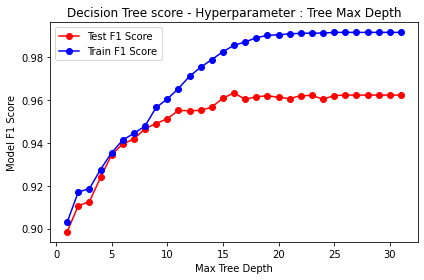


 best decision tree params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 31, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 100, 'splitter': 'best'}

 feature importance:                                     0
SSLfinal_State_1             0.506371
URL_of_Anchor_-1             0.142145
web_traffic_0                0.041216
Links_in_tags_-1             0.033198
Prefix_Suffix                0.027134
having_Sub_Domain_1          0.017811
Request_URL                  0.016222
having_IP_Address            0.012488
Page_Rank                    0.012273
Links_pointing_to_page_1     0.011899
Domain_registeration_length  0.011464
URL_of_Anchor_1              0.011429
DNSRecord                    0.010505
Google_Index                 0.009434
age_of_domain                0.009325
Links_pointing_to_page_0     0.009259
SFH_-1                  

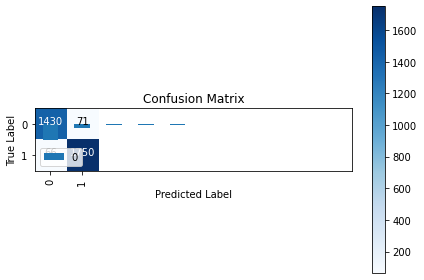

8 39 387 774
wokring on the comprehensive grid search 
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV 1/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=77, min_samples_leaf=8;, score=0.929 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=77, min_samples_leaf=8;, score=0.937 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=77, min_samples_leaf=8;, score=0.928 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=77, min_samples_leaf=8;, score=0.940 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=77, min_samples_leaf=8;, score=0.939 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=77, min_samples_leaf=10;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=77, min_samples_leaf=10;, score=0.939 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=77, min_samples_leaf=10;, scor

[CV 4/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=154, min_samples_leaf=15;, score=0.944 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=154, min_samples_leaf=15;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=154, min_samples_leaf=16;, score=0.934 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=154, min_samples_leaf=16;, score=0.934 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=154, min_samples_leaf=16;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=154, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=154, min_samples_leaf=16;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=154, min_samples_leaf=18;, score=0.931 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=154, min_samples_leaf=1

[CV 4/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=232, min_samples_leaf=23;, score=0.939 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=232, min_samples_leaf=23;, score=0.933 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=309, min_samples_leaf=8;, score=0.928 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=309, min_samples_leaf=8;, score=0.937 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=309, min_samples_leaf=8;, score=0.931 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=309, min_samples_leaf=8;, score=0.940 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=309, min_samples_leaf=8;, score=0.939 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=309, min_samples_leaf=10;, score=0.932 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=309, min_samples_leaf=10;, s

[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=387, min_samples_leaf=15;, score=0.935 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=387, min_samples_leaf=15;, score=0.926 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=387, min_samples_leaf=15;, score=0.944 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=387, min_samples_leaf=15;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=387, min_samples_leaf=16;, score=0.934 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=387, min_samples_leaf=16;, score=0.934 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=387, min_samples_leaf=16;, score=0.926 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=387, min_samples_leaf=16;, score=0.933 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=387, min_samples_leaf=1

[CV 5/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=464, min_samples_leaf=21;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=464, min_samples_leaf=23;, score=0.935 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=464, min_samples_leaf=23;, score=0.930 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=464, min_samples_leaf=23;, score=0.929 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=464, min_samples_leaf=23;, score=0.939 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=464, min_samples_leaf=23;, score=0.933 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=542, min_samples_leaf=8;, score=0.927 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=542, min_samples_leaf=8;, score=0.937 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=542, min_samples_leaf=8;,

[CV 5/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=619, min_samples_leaf=13;, score=0.935 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=619, min_samples_leaf=15;, score=0.928 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=619, min_samples_leaf=15;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=619, min_samples_leaf=15;, score=0.926 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=619, min_samples_leaf=15;, score=0.944 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=619, min_samples_leaf=15;, score=0.931 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=619, min_samples_leaf=16;, score=0.934 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=619, min_samples_leaf=16;, score=0.934 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=619, min_samples_leaf=1

[CV 5/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=697, min_samples_leaf=21;, score=0.931 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=697, min_samples_leaf=23;, score=0.935 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=697, min_samples_leaf=23;, score=0.930 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=697, min_samples_leaf=23;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=697, min_samples_leaf=23;, score=0.939 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=697, min_samples_leaf=23;, score=0.933 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=774, min_samples_leaf=8;, score=0.926 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=774, min_samples_leaf=8;, score=0.937 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=10, max_leaf_nodes=774, min_samples_leaf=8;,

[CV 2/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=77, min_samples_leaf=13;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=77, min_samples_leaf=13;, score=0.925 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=77, min_samples_leaf=13;, score=0.944 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=77, min_samples_leaf=13;, score=0.941 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=77, min_samples_leaf=15;, score=0.928 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=77, min_samples_leaf=15;, score=0.934 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=77, min_samples_leaf=15;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=77, min_samples_leaf=15;, score=0.946 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=77, min_samples_leaf=15;, score

[CV 2/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=154, min_samples_leaf=21;, score=0.933 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=154, min_samples_leaf=21;, score=0.932 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=154, min_samples_leaf=21;, score=0.939 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=154, min_samples_leaf=21;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=154, min_samples_leaf=23;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=154, min_samples_leaf=23;, score=0.930 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=154, min_samples_leaf=23;, score=0.929 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=154, min_samples_leaf=23;, score=0.940 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=154, min_samples_leaf=2

[CV 5/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=309, min_samples_leaf=11;, score=0.940 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=309, min_samples_leaf=13;, score=0.930 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=309, min_samples_leaf=13;, score=0.933 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=309, min_samples_leaf=13;, score=0.925 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=309, min_samples_leaf=13;, score=0.942 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=309, min_samples_leaf=13;, score=0.938 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=309, min_samples_leaf=15;, score=0.927 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=309, min_samples_leaf=15;, score=0.934 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=309, min_samples_leaf=1

[CV 3/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=387, min_samples_leaf=20;, score=0.932 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=387, min_samples_leaf=20;, score=0.937 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=387, min_samples_leaf=20;, score=0.931 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=387, min_samples_leaf=21;, score=0.935 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=387, min_samples_leaf=21;, score=0.933 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=387, min_samples_leaf=21;, score=0.932 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=387, min_samples_leaf=21;, score=0.939 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=387, min_samples_leaf=21;, score=0.931 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=387, min_samples_leaf=2

[CV 1/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=542, min_samples_leaf=11;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=542, min_samples_leaf=11;, score=0.935 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=542, min_samples_leaf=11;, score=0.931 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=542, min_samples_leaf=11;, score=0.942 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=542, min_samples_leaf=11;, score=0.940 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=542, min_samples_leaf=13;, score=0.930 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=542, min_samples_leaf=13;, score=0.933 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=542, min_samples_leaf=13;, score=0.925 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=542, min_samples_leaf=1

[CV 5/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=619, min_samples_leaf=18;, score=0.928 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=619, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=619, min_samples_leaf=20;, score=0.933 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=619, min_samples_leaf=20;, score=0.932 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=619, min_samples_leaf=20;, score=0.937 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=619, min_samples_leaf=20;, score=0.931 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=619, min_samples_leaf=21;, score=0.935 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=619, min_samples_leaf=21;, score=0.933 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=619, min_samples_leaf=2

[CV 4/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=774, min_samples_leaf=10;, score=0.941 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=774, min_samples_leaf=10;, score=0.939 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=774, min_samples_leaf=11;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=774, min_samples_leaf=11;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=774, min_samples_leaf=11;, score=0.931 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=774, min_samples_leaf=11;, score=0.942 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=774, min_samples_leaf=11;, score=0.940 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=774, min_samples_leaf=13;, score=0.930 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=11, max_leaf_nodes=774, min_samples_leaf=1

[CV 2/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=77, min_samples_leaf=18;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=77, min_samples_leaf=18;, score=0.935 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=77, min_samples_leaf=18;, score=0.939 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=77, min_samples_leaf=18;, score=0.928 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=77, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=77, min_samples_leaf=20;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=77, min_samples_leaf=20;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=77, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=77, min_samples_leaf=20;, score

[CV 5/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=232, min_samples_leaf=8;, score=0.947 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=232, min_samples_leaf=10;, score=0.933 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=232, min_samples_leaf=10;, score=0.933 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=232, min_samples_leaf=10;, score=0.930 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=232, min_samples_leaf=10;, score=0.944 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=232, min_samples_leaf=10;, score=0.940 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=232, min_samples_leaf=11;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=232, min_samples_leaf=11;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=232, min_samples_leaf=11

[CV 2/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=309, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=309, min_samples_leaf=16;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=309, min_samples_leaf=16;, score=0.936 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=309, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=309, min_samples_leaf=18;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=309, min_samples_leaf=18;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=309, min_samples_leaf=18;, score=0.935 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=309, min_samples_leaf=18;, score=0.939 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=309, min_samples_leaf=1

[CV 1/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=464, min_samples_leaf=8;, score=0.934 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=464, min_samples_leaf=8;, score=0.932 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=464, min_samples_leaf=8;, score=0.925 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=464, min_samples_leaf=8;, score=0.942 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=464, min_samples_leaf=8;, score=0.947 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=464, min_samples_leaf=10;, score=0.931 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=464, min_samples_leaf=10;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=464, min_samples_leaf=10;, score=0.930 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=464, min_samples_leaf=10;, s

[CV 3/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=542, min_samples_leaf=15;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=542, min_samples_leaf=15;, score=0.949 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=542, min_samples_leaf=15;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=542, min_samples_leaf=16;, score=0.934 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=542, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=542, min_samples_leaf=16;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=542, min_samples_leaf=16;, score=0.936 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=542, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=542, min_samples_leaf=1

[CV 5/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=619, min_samples_leaf=21;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=619, min_samples_leaf=23;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=619, min_samples_leaf=23;, score=0.930 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=619, min_samples_leaf=23;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=619, min_samples_leaf=23;, score=0.940 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=619, min_samples_leaf=23;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=697, min_samples_leaf=8;, score=0.931 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=697, min_samples_leaf=8;, score=0.932 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=697, min_samples_leaf=8;,

[CV 2/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=774, min_samples_leaf=13;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=774, min_samples_leaf=13;, score=0.925 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=774, min_samples_leaf=13;, score=0.946 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=774, min_samples_leaf=13;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=774, min_samples_leaf=15;, score=0.927 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=774, min_samples_leaf=15;, score=0.934 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=774, min_samples_leaf=15;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=774, min_samples_leaf=15;, score=0.949 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=12, max_leaf_nodes=774, min_samples_leaf=1

[CV 1/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=77, min_samples_leaf=21;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=77, min_samples_leaf=21;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=77, min_samples_leaf=21;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=77, min_samples_leaf=21;, score=0.937 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=77, min_samples_leaf=21;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=77, min_samples_leaf=23;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=77, min_samples_leaf=23;, score=0.930 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=77, min_samples_leaf=23;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=77, min_samples_leaf=23;, score

[CV 3/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=232, min_samples_leaf=11;, score=0.931 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=232, min_samples_leaf=11;, score=0.947 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=232, min_samples_leaf=11;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=232, min_samples_leaf=13;, score=0.930 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=232, min_samples_leaf=13;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=232, min_samples_leaf=13;, score=0.925 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=232, min_samples_leaf=13;, score=0.946 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=232, min_samples_leaf=13;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=232, min_samples_leaf=1

[CV 5/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=309, min_samples_leaf=18;, score=0.928 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=309, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=309, min_samples_leaf=20;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=309, min_samples_leaf=20;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=309, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=309, min_samples_leaf=20;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=309, min_samples_leaf=21;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=309, min_samples_leaf=21;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=309, min_samples_leaf=2

[CV 3/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=464, min_samples_leaf=10;, score=0.930 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=464, min_samples_leaf=10;, score=0.943 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=464, min_samples_leaf=10;, score=0.940 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=464, min_samples_leaf=11;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=464, min_samples_leaf=11;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=464, min_samples_leaf=11;, score=0.931 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=464, min_samples_leaf=11;, score=0.947 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=464, min_samples_leaf=11;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=464, min_samples_leaf=1

[CV 1/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=542, min_samples_leaf=18;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=542, min_samples_leaf=18;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=542, min_samples_leaf=18;, score=0.935 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=542, min_samples_leaf=18;, score=0.939 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=542, min_samples_leaf=18;, score=0.928 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=542, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=542, min_samples_leaf=20;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=542, min_samples_leaf=20;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=542, min_samples_leaf=2

[CV 3/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=697, min_samples_leaf=8;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=697, min_samples_leaf=8;, score=0.941 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=697, min_samples_leaf=8;, score=0.948 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=697, min_samples_leaf=10;, score=0.931 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=697, min_samples_leaf=10;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=697, min_samples_leaf=10;, score=0.930 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=697, min_samples_leaf=10;, score=0.943 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=697, min_samples_leaf=10;, score=0.940 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=697, min_samples_leaf=11;,

[CV 5/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=774, min_samples_leaf=15;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=774, min_samples_leaf=16;, score=0.934 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=774, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=774, min_samples_leaf=16;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=774, min_samples_leaf=16;, score=0.936 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=774, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=774, min_samples_leaf=18;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=774, min_samples_leaf=18;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=13, max_leaf_nodes=774, min_samples_leaf=1

[CV 2/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=77, min_samples_leaf=23;, score=0.930 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=77, min_samples_leaf=23;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=77, min_samples_leaf=23;, score=0.940 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=77, min_samples_leaf=23;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=154, min_samples_leaf=8;, score=0.931 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=154, min_samples_leaf=8;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=154, min_samples_leaf=8;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=154, min_samples_leaf=8;, score=0.938 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=154, min_samples_leaf=8;, score

[CV 1/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=232, min_samples_leaf=15;, score=0.927 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=232, min_samples_leaf=15;, score=0.934 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=232, min_samples_leaf=15;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=232, min_samples_leaf=15;, score=0.949 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=232, min_samples_leaf=15;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=232, min_samples_leaf=16;, score=0.934 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=232, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=232, min_samples_leaf=16;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=232, min_samples_leaf=1

[CV 3/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=309, min_samples_leaf=21;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=309, min_samples_leaf=21;, score=0.937 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=309, min_samples_leaf=21;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=309, min_samples_leaf=23;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=309, min_samples_leaf=23;, score=0.930 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=309, min_samples_leaf=23;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=309, min_samples_leaf=23;, score=0.940 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=309, min_samples_leaf=23;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=387, min_samples_leaf=8

[CV 1/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=464, min_samples_leaf=13;, score=0.930 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=464, min_samples_leaf=13;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=464, min_samples_leaf=13;, score=0.925 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=464, min_samples_leaf=13;, score=0.946 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=464, min_samples_leaf=13;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=464, min_samples_leaf=15;, score=0.927 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=464, min_samples_leaf=15;, score=0.934 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=464, min_samples_leaf=15;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=464, min_samples_leaf=1

[CV 4/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=542, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=542, min_samples_leaf=20;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=542, min_samples_leaf=21;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=542, min_samples_leaf=21;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=542, min_samples_leaf=21;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=542, min_samples_leaf=21;, score=0.937 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=542, min_samples_leaf=21;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=542, min_samples_leaf=23;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=542, min_samples_leaf=2

[CV 3/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=697, min_samples_leaf=11;, score=0.931 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=697, min_samples_leaf=11;, score=0.948 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=697, min_samples_leaf=11;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=697, min_samples_leaf=13;, score=0.930 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=697, min_samples_leaf=13;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=697, min_samples_leaf=13;, score=0.925 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=697, min_samples_leaf=13;, score=0.946 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=697, min_samples_leaf=13;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=697, min_samples_leaf=1

[CV 1/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=774, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=774, min_samples_leaf=20;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=774, min_samples_leaf=20;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=774, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=774, min_samples_leaf=20;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=774, min_samples_leaf=21;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=774, min_samples_leaf=21;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=774, min_samples_leaf=21;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=14, max_leaf_nodes=774, min_samples_leaf=2

[CV 3/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=154, min_samples_leaf=10;, score=0.930 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=154, min_samples_leaf=10;, score=0.944 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=154, min_samples_leaf=10;, score=0.940 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=154, min_samples_leaf=11;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=154, min_samples_leaf=11;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=154, min_samples_leaf=11;, score=0.931 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=154, min_samples_leaf=11;, score=0.948 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=154, min_samples_leaf=11;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=154, min_samples_leaf=1

[CV 5/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=232, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=232, min_samples_leaf=18;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=232, min_samples_leaf=18;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=232, min_samples_leaf=18;, score=0.935 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=232, min_samples_leaf=18;, score=0.939 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=232, min_samples_leaf=18;, score=0.928 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=232, min_samples_leaf=20;, score=0.935 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=232, min_samples_leaf=20;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=232, min_samples_leaf=2

[CV 5/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=387, min_samples_leaf=8;, score=0.948 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=387, min_samples_leaf=10;, score=0.933 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=387, min_samples_leaf=10;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=387, min_samples_leaf=10;, score=0.930 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=387, min_samples_leaf=10;, score=0.944 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=387, min_samples_leaf=10;, score=0.940 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=387, min_samples_leaf=11;, score=0.932 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=387, min_samples_leaf=11;, score=0.935 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=387, min_samples_leaf=11

[CV 2/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=464, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=464, min_samples_leaf=16;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=464, min_samples_leaf=16;, score=0.936 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=464, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=464, min_samples_leaf=18;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=464, min_samples_leaf=18;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=464, min_samples_leaf=18;, score=0.935 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=464, min_samples_leaf=18;, score=0.939 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=464, min_samples_leaf=1

[CV 1/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=619, min_samples_leaf=8;, score=0.933 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=619, min_samples_leaf=8;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=619, min_samples_leaf=8;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=619, min_samples_leaf=8;, score=0.940 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=619, min_samples_leaf=8;, score=0.948 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=619, min_samples_leaf=10;, score=0.933 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=619, min_samples_leaf=10;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=619, min_samples_leaf=10;, score=0.930 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=619, min_samples_leaf=10;, s

[CV 1/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=697, min_samples_leaf=16;, score=0.934 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=697, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=697, min_samples_leaf=16;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=697, min_samples_leaf=16;, score=0.936 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=697, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=697, min_samples_leaf=18;, score=0.931 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=697, min_samples_leaf=18;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=697, min_samples_leaf=18;, score=0.935 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=697, min_samples_leaf=1

[CV 5/5] END ccp_alpha=0.0, max_depth=15, max_leaf_nodes=774, min_samples_leaf=23;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=77, min_samples_leaf=8;, score=0.936 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=77, min_samples_leaf=8;, score=0.932 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=77, min_samples_leaf=8;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=77, min_samples_leaf=8;, score=0.942 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=77, min_samples_leaf=8;, score=0.942 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=77, min_samples_leaf=10;, score=0.933 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=77, min_samples_leaf=10;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=77, min_samples_leaf=10;, score=0.9

[CV 5/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=154, min_samples_leaf=15;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=154, min_samples_leaf=16;, score=0.934 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=154, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=154, min_samples_leaf=16;, score=0.926 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=154, min_samples_leaf=16;, score=0.936 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=154, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=154, min_samples_leaf=18;, score=0.931 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=154, min_samples_leaf=18;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=154, min_samples_leaf=1

[CV 2/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=232, min_samples_leaf=23;, score=0.930 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=232, min_samples_leaf=23;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=232, min_samples_leaf=23;, score=0.940 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=232, min_samples_leaf=23;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=309, min_samples_leaf=8;, score=0.931 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=309, min_samples_leaf=8;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=309, min_samples_leaf=8;, score=0.926 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=309, min_samples_leaf=8;, score=0.937 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=309, min_samples_leaf=8;, s

[CV 4/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=387, min_samples_leaf=13;, score=0.946 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=387, min_samples_leaf=13;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=387, min_samples_leaf=15;, score=0.927 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=387, min_samples_leaf=15;, score=0.934 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=387, min_samples_leaf=15;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=387, min_samples_leaf=15;, score=0.949 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=387, min_samples_leaf=15;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=387, min_samples_leaf=16;, score=0.934 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=387, min_samples_leaf=1

[CV 3/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=464, min_samples_leaf=21;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=464, min_samples_leaf=21;, score=0.937 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=464, min_samples_leaf=21;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=464, min_samples_leaf=23;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=464, min_samples_leaf=23;, score=0.930 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=464, min_samples_leaf=23;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=464, min_samples_leaf=23;, score=0.940 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=464, min_samples_leaf=23;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=542, min_samples_leaf=8

[CV 1/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=619, min_samples_leaf=13;, score=0.930 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=619, min_samples_leaf=13;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=619, min_samples_leaf=13;, score=0.925 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=619, min_samples_leaf=13;, score=0.946 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=619, min_samples_leaf=13;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=619, min_samples_leaf=15;, score=0.927 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=619, min_samples_leaf=15;, score=0.934 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=619, min_samples_leaf=15;, score=0.929 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=619, min_samples_leaf=1

[CV 3/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=697, min_samples_leaf=20;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=697, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=697, min_samples_leaf=20;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=697, min_samples_leaf=21;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=697, min_samples_leaf=21;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=697, min_samples_leaf=21;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=697, min_samples_leaf=21;, score=0.937 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=697, min_samples_leaf=21;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=16, max_leaf_nodes=697, min_samples_leaf=2

[CV 2/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=77, min_samples_leaf=11;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=77, min_samples_leaf=11;, score=0.930 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=77, min_samples_leaf=11;, score=0.946 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=77, min_samples_leaf=11;, score=0.936 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=77, min_samples_leaf=13;, score=0.931 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=77, min_samples_leaf=13;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=77, min_samples_leaf=13;, score=0.925 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=77, min_samples_leaf=13;, score=0.948 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=77, min_samples_leaf=13;, score

[CV 4/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=154, min_samples_leaf=18;, score=0.939 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=154, min_samples_leaf=18;, score=0.928 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=154, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=154, min_samples_leaf=20;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=154, min_samples_leaf=20;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=154, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=154, min_samples_leaf=20;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=154, min_samples_leaf=21;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=154, min_samples_leaf=2

[CV 4/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=309, min_samples_leaf=10;, score=0.944 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=309, min_samples_leaf=10;, score=0.940 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=309, min_samples_leaf=11;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=309, min_samples_leaf=11;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=309, min_samples_leaf=11;, score=0.931 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=309, min_samples_leaf=11;, score=0.948 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=309, min_samples_leaf=11;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=309, min_samples_leaf=13;, score=0.930 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=309, min_samples_leaf=1

[CV 4/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=387, min_samples_leaf=18;, score=0.939 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=387, min_samples_leaf=18;, score=0.928 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=387, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=387, min_samples_leaf=20;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=387, min_samples_leaf=20;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=387, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=387, min_samples_leaf=20;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=387, min_samples_leaf=21;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=387, min_samples_leaf=2

[CV 1/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=542, min_samples_leaf=10;, score=0.931 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=542, min_samples_leaf=10;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=542, min_samples_leaf=10;, score=0.930 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=542, min_samples_leaf=10;, score=0.944 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=542, min_samples_leaf=10;, score=0.940 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=542, min_samples_leaf=11;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=542, min_samples_leaf=11;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=542, min_samples_leaf=11;, score=0.931 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=542, min_samples_leaf=1

[CV 3/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=619, min_samples_leaf=16;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=619, min_samples_leaf=16;, score=0.936 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=619, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=619, min_samples_leaf=18;, score=0.931 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=619, min_samples_leaf=18;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=619, min_samples_leaf=18;, score=0.935 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=619, min_samples_leaf=18;, score=0.939 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=619, min_samples_leaf=18;, score=0.928 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=619, min_samples_leaf=2

[CV 1/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=774, min_samples_leaf=8;, score=0.930 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=774, min_samples_leaf=8;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=774, min_samples_leaf=8;, score=0.926 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=774, min_samples_leaf=8;, score=0.940 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=774, min_samples_leaf=8;, score=0.948 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=774, min_samples_leaf=10;, score=0.933 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=774, min_samples_leaf=10;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=774, min_samples_leaf=10;, score=0.930 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=17, max_leaf_nodes=774, min_samples_leaf=10;, s

[CV 1/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=77, min_samples_leaf=16;, score=0.934 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=77, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=77, min_samples_leaf=16;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=77, min_samples_leaf=16;, score=0.941 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=77, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=77, min_samples_leaf=18;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=77, min_samples_leaf=18;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=77, min_samples_leaf=18;, score=0.935 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=77, min_samples_leaf=18;, score

[CV 1/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=232, min_samples_leaf=8;, score=0.934 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=232, min_samples_leaf=8;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=232, min_samples_leaf=8;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=232, min_samples_leaf=8;, score=0.940 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=232, min_samples_leaf=8;, score=0.948 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=232, min_samples_leaf=10;, score=0.933 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=232, min_samples_leaf=10;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=232, min_samples_leaf=10;, score=0.930 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=232, min_samples_leaf=10;, s

[CV 4/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=309, min_samples_leaf=15;, score=0.949 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=309, min_samples_leaf=15;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=309, min_samples_leaf=16;, score=0.934 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=309, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=309, min_samples_leaf=16;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=309, min_samples_leaf=16;, score=0.936 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=309, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=309, min_samples_leaf=18;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=309, min_samples_leaf=1

[CV 3/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=387, min_samples_leaf=23;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=387, min_samples_leaf=23;, score=0.940 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=387, min_samples_leaf=23;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=464, min_samples_leaf=8;, score=0.931 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=464, min_samples_leaf=8;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=464, min_samples_leaf=8;, score=0.928 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=464, min_samples_leaf=8;, score=0.937 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=464, min_samples_leaf=8;, score=0.948 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=464, min_samples_leaf=10;, s

[CV 2/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=542, min_samples_leaf=15;, score=0.934 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=542, min_samples_leaf=15;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=542, min_samples_leaf=15;, score=0.949 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=542, min_samples_leaf=15;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=542, min_samples_leaf=16;, score=0.934 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=542, min_samples_leaf=16;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=542, min_samples_leaf=16;, score=0.926 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=542, min_samples_leaf=16;, score=0.936 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=542, min_samples_leaf=1

[CV 4/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=619, min_samples_leaf=21;, score=0.937 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=619, min_samples_leaf=21;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=619, min_samples_leaf=23;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=619, min_samples_leaf=23;, score=0.930 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=619, min_samples_leaf=23;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=619, min_samples_leaf=23;, score=0.940 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=619, min_samples_leaf=23;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=697, min_samples_leaf=8;, score=0.931 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=697, min_samples_leaf=8;

[CV 3/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=774, min_samples_leaf=13;, score=0.925 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=774, min_samples_leaf=13;, score=0.946 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=774, min_samples_leaf=13;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=774, min_samples_leaf=15;, score=0.927 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=774, min_samples_leaf=15;, score=0.934 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=774, min_samples_leaf=15;, score=0.929 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=774, min_samples_leaf=15;, score=0.949 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=774, min_samples_leaf=15;, score=0.933 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=18, max_leaf_nodes=774, min_samples_leaf=1

[CV 5/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=77, min_samples_leaf=20;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=77, min_samples_leaf=21;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=77, min_samples_leaf=21;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=77, min_samples_leaf=21;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=77, min_samples_leaf=21;, score=0.937 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=77, min_samples_leaf=21;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=77, min_samples_leaf=23;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=77, min_samples_leaf=23;, score=0.930 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=77, min_samples_leaf=23;, score

[CV 5/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=232, min_samples_leaf=11;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=232, min_samples_leaf=13;, score=0.930 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=232, min_samples_leaf=13;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=232, min_samples_leaf=13;, score=0.925 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=232, min_samples_leaf=13;, score=0.946 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=232, min_samples_leaf=13;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=232, min_samples_leaf=15;, score=0.927 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=232, min_samples_leaf=15;, score=0.934 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=232, min_samples_leaf=1

[CV 5/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=309, min_samples_leaf=20;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=309, min_samples_leaf=21;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=309, min_samples_leaf=21;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=309, min_samples_leaf=21;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=309, min_samples_leaf=21;, score=0.937 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=309, min_samples_leaf=21;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=309, min_samples_leaf=23;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=309, min_samples_leaf=23;, score=0.930 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=309, min_samples_leaf=2

[CV 2/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=464, min_samples_leaf=11;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=464, min_samples_leaf=11;, score=0.931 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=464, min_samples_leaf=11;, score=0.948 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=464, min_samples_leaf=11;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=464, min_samples_leaf=13;, score=0.930 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=464, min_samples_leaf=13;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=464, min_samples_leaf=13;, score=0.925 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=464, min_samples_leaf=13;, score=0.946 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=464, min_samples_leaf=1

[CV 5/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=542, min_samples_leaf=18;, score=0.928 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=542, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=542, min_samples_leaf=20;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=542, min_samples_leaf=20;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=542, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=542, min_samples_leaf=20;, score=0.931 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=542, min_samples_leaf=21;, score=0.935 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=542, min_samples_leaf=21;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=542, min_samples_leaf=2

[CV 5/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=697, min_samples_leaf=10;, score=0.940 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=697, min_samples_leaf=11;, score=0.932 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=697, min_samples_leaf=11;, score=0.935 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=697, min_samples_leaf=11;, score=0.931 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=697, min_samples_leaf=11;, score=0.948 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=697, min_samples_leaf=11;, score=0.941 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=697, min_samples_leaf=13;, score=0.930 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=697, min_samples_leaf=13;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=697, min_samples_leaf=1

[CV 2/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=774, min_samples_leaf=18;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=774, min_samples_leaf=18;, score=0.935 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=774, min_samples_leaf=18;, score=0.939 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=774, min_samples_leaf=18;, score=0.928 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=774, min_samples_leaf=20;, score=0.935 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=774, min_samples_leaf=20;, score=0.933 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=774, min_samples_leaf=20;, score=0.932 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=774, min_samples_leaf=20;, score=0.935 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=19, max_leaf_nodes=774, min_samples_leaf=2

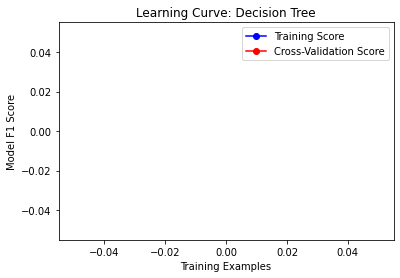

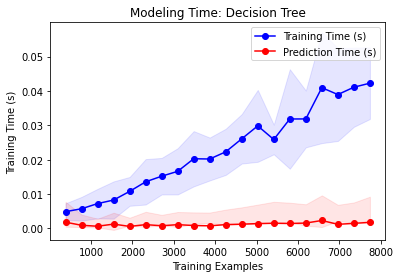

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.04380
Model Prediction Time (s): 0.01351

F1 Score:  0.95
Accuracy:  0.95     AUC:       0.95
Precision: 0.95     Recall:    0.95
*****************************************************


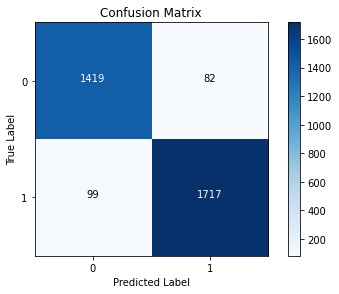

In [36]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error


# notes
# f1_score: a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
# F1 = 2 * (precision * recall) / (precision + recall)

# train decision tree, with max depth searcher
def trainDT(x_train, y_train, x_test, y_test, feature_names, maxdepth = 32):

    f1_train = [] # to store the score of training dataset
    f1_test = [] # to store the score of test dataset
    max_depth = list(range(1, maxdepth)) # for plotting
    
    maxScore = 0
    for i in max_depth:         
        clf = DecisionTreeClassifier(max_depth=i, random_state=100, min_samples_leaf=1, criterion='entropy')
        clf.fit(x_train, y_train)

        y_pred_train = clf.predict(x_train)
        f1_train.append(f1_score(y_train, y_pred_train,pos_label='1'))

        y_pred_test = clf.predict(x_test)
        newScore = f1_score(y_test, y_pred_test,pos_label='1')
        if newScore>maxScore: bestDT = clf
        f1_test.append(newScore)

    plotScoreVSDepth(max_depth, f1_test, f1_train, "Decision Tree score - Hyperparameter : Tree Max Depth")

    
    print(f"\n best decision tree params: {bestDT.get_params()}") # to get the decision tree parameters
    
    featuresDF = pd.DataFrame(bestDT.feature_importances_, index=feature_names).sort_values(0,ascending=False)
    
    print(f"\n feature importance: {featuresDF}") # tells you which feature has the highest weight. 

    featuresDF.head(10).plot(kind='bar')
    
    
    print(f"\n probabilities: {clf.predict_proba(x_test)}")
    
    bestScore = max(f1_test) # should be equal to maxScore
    bestIndex = f1_test.index(bestScore)
    print(f"best tree is {bestIndex} level deep with a score of { bestScore }.")

    y_pred = bestDT.predict(x_test)
    
    model_evaluation(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)    
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')

#     plotDecisionTree(bestDT, feature_names)
    
    return bestIndex, bestScore
        

# comprehensive Decision Tree optimizer
def DecitionTreeOptimizer_GridSearchCV(X_train, y_train, min_min_sample_leaf, max_min_sample_leaf_n, 
                                       min_depth,max_depth, min_max_leaf_nodes, max_max_leaf_nodes):

    #parameters to search:
    # 1- max_leaf_nodes (provides a very sensible way to control overfitting vs underfitting. 
    #    The more leaves we allow the model to make, the more we move from the underfitting area in the above 
    #    graph to the overfitting area.)
    # 2- max_depth: from 1 to max_depth-the higher the depth, the more the chance of overfitting
    # 3- min_samples_leaf: the smaller the number, the higher the chance we have overftting
    param_grid = {'min_samples_leaf':np.linspace(min_min_sample_leaf, max_min_sample_leaf_n,10).round().astype('int'), 
                  'max_depth':np.arange(min_depth,max_depth), 
                  'max_leaf_nodes':np.linspace(min_max_leaf_nodes, max_max_leaf_nodes,10).round().astype('int'), 
                  'ccp_alpha': [0.0]} # , 0.01, 0.05

    #Exhaustive search over specified parameter values for an estimator.
    tree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_grid, cv=5, verbose=3) #cv stritifiedKFold?!
    tree.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(tree.best_params_)
    return tree.best_params_['max_depth'], tree.best_params_['min_samples_leaf'], tree.best_params_['max_leaf_nodes']




# training a decision tree classifier with max depth optimizer (simpler decision tree). 
trainDT(x_train, y_train, x_test, y_test,feature_names)

print(round(0.001*len(x_train)), round(0.005*len(x_train)),round(0.05*len(x_train)), round(0.1*len(x_train)))

print("wokring on the comprehensive grid search ")
max_depth, min_samples_leaf, max_leaf_nodes = DecitionTreeOptimizer_GridSearchCV(x_train, y_train, 
                                              round(0.001*len(x_train)), round(0.003*len(x_train)),
                                              10,20,
                                              round(0.01*len(x_train)), round(0.1*len(x_train))
                                              )

print(" best tree")
estimator_data = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                                        max_leaf_nodes=max_leaf_nodes, random_state=100, criterion='entropy')

train_samp_data, DT_train_score_data, DT_fit_time_data, DT_pred_time_data = plot_learning_curve(estimator_data, 
                                                                        x_train, y_train,title="Decision Tree")
final_classifier_evaluation(estimator_data, x_train, x_test, y_train, y_test)



## Random forest

In [41]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(x_train, y_train)
y_pred = forest_model.predict(x_test)


model_evaluation(y_test, y_pred)



mean abs error:  0.03
F1 Score:  0.97
Accuracy:  0.97     AUC:          0.97
Accuracy:  0.97  Accuracy:     0.97
Precision: 0.97  Precision: 0.97
Precision: 0.97     Recall:    0.97
